# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></div><div class="lev1 toc-item"><a href="#Load-data" data-toc-modified-id="Load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data</a></div><div class="lev1 toc-item"><a href="#Set-up-data" data-toc-modified-id="Set-up-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Set up data</a></div><div class="lev2 toc-item"><a href="#Get-data-overlap" data-toc-modified-id="Get-data-overlap-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Get data overlap</a></div><div class="lev1 toc-item"><a href="#Decision-trees" data-toc-modified-id="Decision-trees-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Decision trees</a></div><div class="lev2 toc-item"><a href="#NSRDB-data" data-toc-modified-id="NSRDB-data-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>NSRDB data</a></div><div class="lev3 toc-item"><a href="#Default-tree" data-toc-modified-id="Default-tree-411"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Default tree</a></div><div class="lev3 toc-item"><a href="#Max-depth-tree" data-toc-modified-id="Max-depth-tree-412"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>Max depth tree</a></div><div class="lev2 toc-item"><a href="#Ratio" data-toc-modified-id="Ratio-42"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Ratio</a></div><div class="lev3 toc-item"><a href="#NSRDB" data-toc-modified-id="NSRDB-421"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>NSRDB</a></div><div class="lev3 toc-item"><a href="#Ground-data" data-toc-modified-id="Ground-data-422"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>Ground data</a></div><div class="lev4 toc-item"><a href="#First-run" data-toc-modified-id="First-run-4221"><span class="toc-item-num">4.2.2.1&nbsp;&nbsp;</span>First run</a></div><div class="lev4 toc-item"><a href="#Second-run" data-toc-modified-id="Second-run-4222"><span class="toc-item-num">4.2.2.2&nbsp;&nbsp;</span>Second run</a></div>

# Introduction

This notebook will investigate training decision trees on NSRDB data and applying them detect clarity based on ground measurements.  The features initially investigated will be GHI, Clearsky GHI, and the GHI:GHI_cs ratio.  These features may not necessarily be the best ones, but they are fairly obvious candidates to start with.

# Load data

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pytz
import itertools

import pvlib
import utils

import concurrent.futures

np.set_printoptions(precision=4)
%matplotlib notebook

In [2]:
nsrdb_df = pd.read_pickle('./abq_nsrdb_df.pkl')
ground_df = pd.read_pickle('./abq_ground_df.pkl')

# Set up data

## Get data overlap

In [3]:
intersection = nsrdb_df.index.intersection(ground_df.index)
EARLIEST_IDX = intersection[0]
LATEST_IDX = intersection[-1]
print('NSRDB date range: {} -> {}'.format(nsrdb_df.index[0], nsrdb_df.index[-1]))
print('Ground date range: {} -> {}'.format(ground_df.index[0], ground_df.index[-1]))
print('Earliest intersection: {}, latest intersection: {}'.format(EARLIEST_IDX, LATEST_IDX))

NSRDB date range: 1997-12-31 17:00:00-07:00 -> 2015-12-31 16:30:00-07:00
Ground date range: 2015-01-08 22:31:00-07:00 -> 2017-04-06 01:00:00-06:00
Earliest intersection: 2015-01-08 23:00:00-07:00, latest intersection: 2015-12-31 16:30:00-07:00


In [4]:
intersection = intersection[intersection >= '10-01-2015']

# Decision trees

In [5]:
from sklearn import tree
from sklearn import model_selection
from sklearn import metrics
from IPython.display import Image

def fit_model(clf, df, cols):
    X = df[cols[:-1]].values
    y = df[cols[-1]].astype(int).values
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)
    scores = model_selection.cross_val_score(estimator=clf, X=X_train, y=y_train)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    test_score = metrics.accuracy_score(y_test, y_pred)
    print('CV scoring: {} +/ -  {}'.format(np.round(np.mean(scores), 4), np.round(np.std(scores), 4)))
    print('Test score: {}'.format(test_score))
    conf_mat = metrics.confusion_matrix(y_test, y_pred)
    utils.plot_confusion_matrix(conf_mat, ['cloudy', 'clear'])
    return clf

def fit_model_cv_grid(clf, df, cols, param_grid):
    X = df[cols[:-1]].values
    y = df[cols[-1]].astype(int).values
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)
    clf_cv = model_selection.GridSearchCV(clf, param_grid)
    clf_cv.fit(X_train, y_train)
    # MAX_DEPTH = clf_cv.best_estimator_.max_depth
    y_pred = clf_cv.predict(X_test)
    test_score = metrics.accuracy_score(y_test, y_pred)
    conf_mat = metrics.confusion_matrix(y_test, y_pred)
    utils.plot_confusion_matrix(conf_mat, ['cloudy', 'clear'])
    return clf_cv

## NSRDB data

### Default tree

CV scoring: 0.9481 +/ -  0.0006
Test score: 0.9492571747287294


<IPython.core.display.Javascript object>


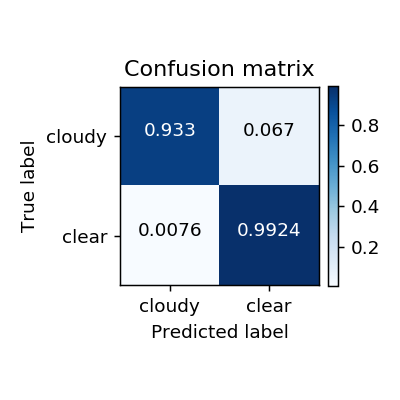

In [6]:
cols = ['GHI', 'Clearsky GHI', 'ratio', 'sky_status']
dt = tree.DecisionTreeClassifier()
dt = fit_model(dt, nsrdb_df, cols)

In [7]:
tree.export_graphviz(dt, out_file='2_abq_default_dt.dot', feature_names=cols[:-1], class_names=['cloudy', 'clear'])
# !dot -Tpng 2_abq_default_dt.dot -o 2_abq_default_dt.png

In [8]:
# Image('2_abq_default_dt.png')
# this is a very large file - if you want to view it do not use the notebook - it will be come terribly slow.

Tree is overly complex and difficult to interpret.  Will start by limiting the depth of the tree (using cross val).

### Max depth tree

<IPython.core.display.Javascript object>


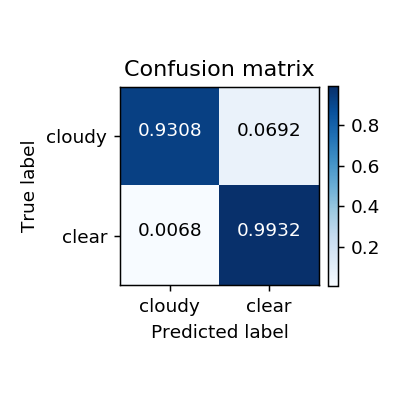

In [9]:
cols = ['GHI', 'Clearsky GHI', 'ratio', 'sky_status']
param_grid = {'max_depth': [i for i in range(2, 15)]}
dt = tree.DecisionTreeClassifier()
clf_cv = fit_model_cv_grid(dt, nsrdb_df, cols, param_grid)
dt = clf_cv.best_estimator_

In [10]:
print('Optimal max depth: ', dt.max_depth)
MAX_DEPTH = dt.max_depth
MAX_DEPTH = 3

Optimal max depth:  7


In [11]:
tree.export_graphviz(dt, out_file='2_abq_opt_dt.dot',feature_names=cols[:-1], class_names=['cloudy', 'clear'])
!dot -Tpng 2_abq_opt_dt.dot -o 2_abq_opt_dt.png

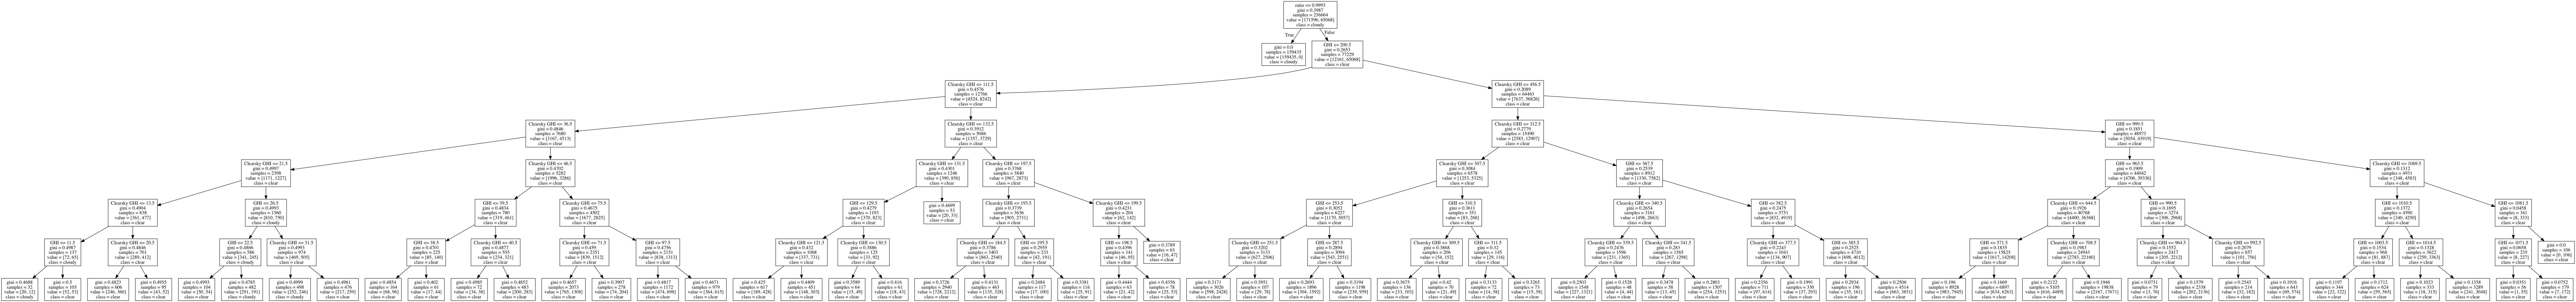

In [12]:
Image('2_abq_opt_dt.png')

Tree is still quite complex, but we will stick with this for now.  Limiting depth further may help debug or troubleshoot fitting DT to sky classification.

<IPython.core.display.Javascript object>


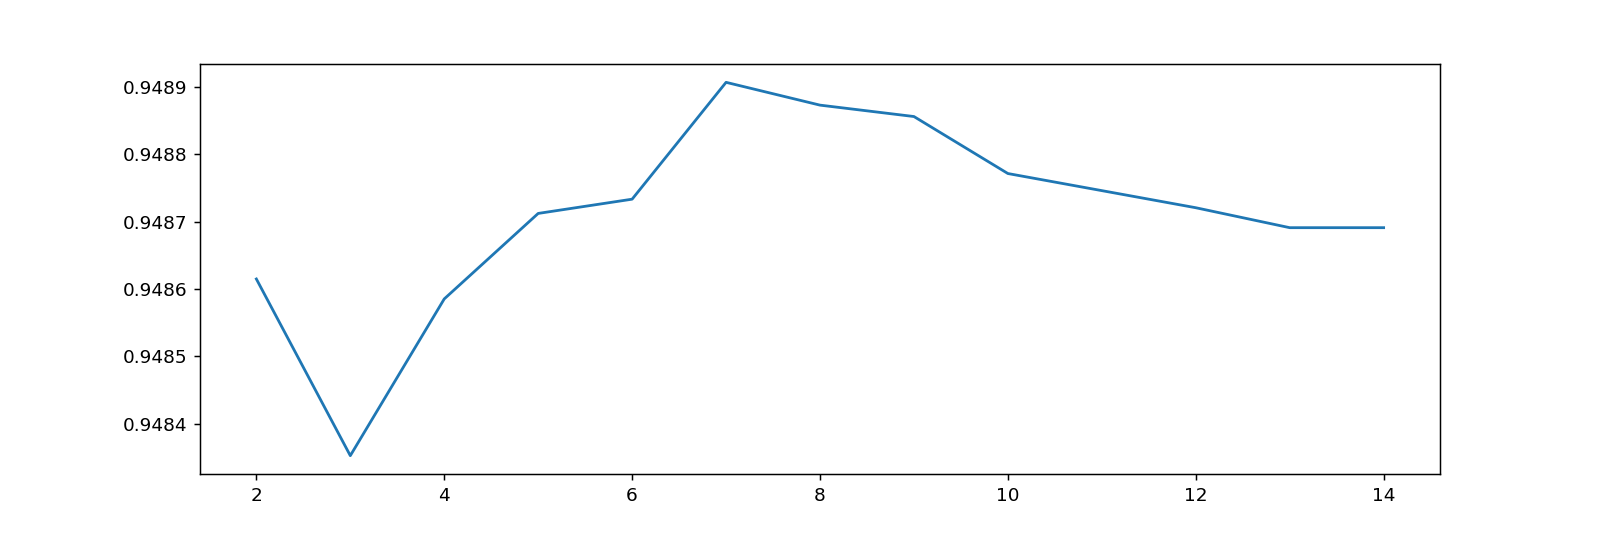

In [13]:
scores = clf_cv.cv_results_['mean_test_score']
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(list(range(2, 15)), scores)

There isn't a huge benefit to using max depth of 7 vs 2 or 3 (which would be much easier to inperpret).  The difference in score is negligible at a difference of about .0002.

### NSRDB

In [14]:
train_df = nsrdb_df[nsrdb_df.index < '01-01-2015']
test_df = nsrdb_df[nsrdb_df.index >= '01-01-2015']

In [15]:
cols = ['GHI', 'Clearsky GHI', 'ratio', 'sky_status']
dt = tree.DecisionTreeClassifier(max_depth=MAX_DEPTH)
dt.fit(train_df[cols[:-1]].values, train_df[cols[-1]].values)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [16]:
predicted_clear = dt.predict(test_df[cols[:-1]])

<IPython.core.display.Javascript object>


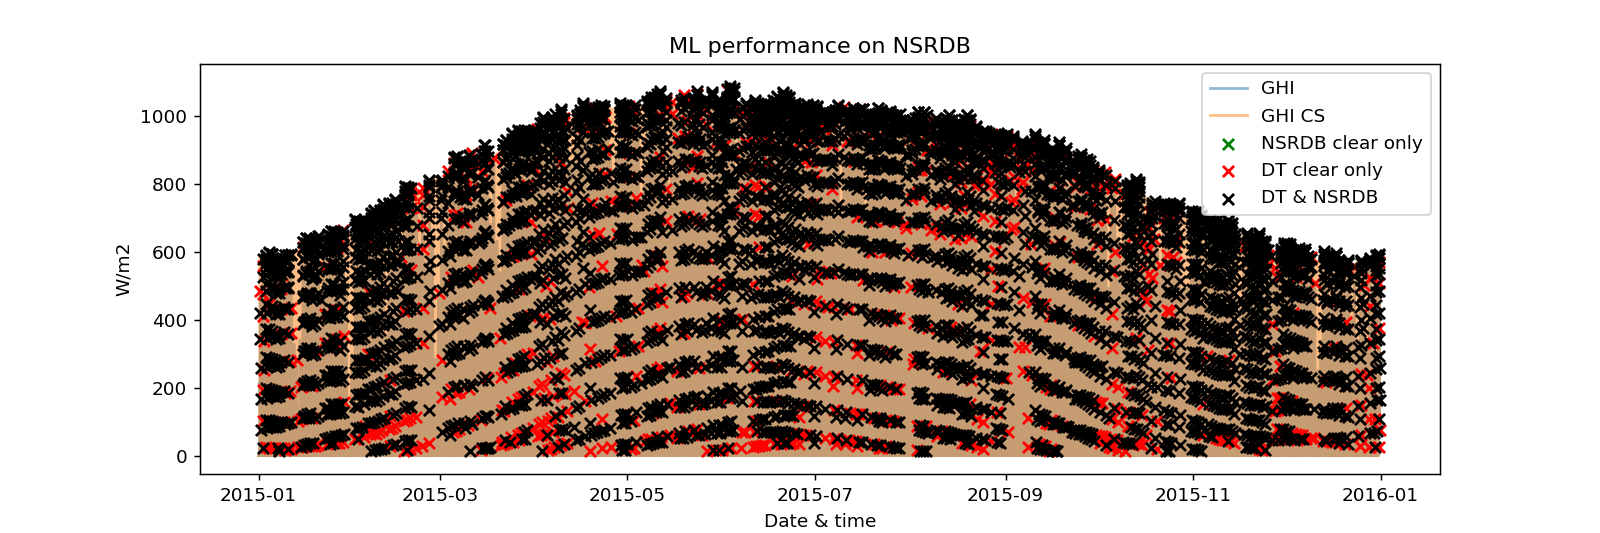

In [17]:
fig, ax = plt.subplots(figsize=(12, 4))

p1 = ax.plot(test_df.index, test_df['GHI'], label='GHI', alpha=.5)
p2 = ax.plot(test_df.index, test_df['Clearsky GHI'], label='GHI CS', alpha=.5)

p3 = ax.scatter(test_df[~(predicted_clear) & (test_df['sky_status'] == 1)].index, 
                test_df[~(predicted_clear) & (test_df['sky_status'] == 1)]['GHI'],
                marker='x', color='green', label='NSRDB clear only', zorder=10)

p4 = ax.scatter(test_df[(predicted_clear) & ~(test_df['sky_status'] == 1)].index, 
                test_df[(predicted_clear) & ~(test_df['sky_status'] == 1)]['GHI'],
                marker='x', color='red', label='DT clear only', zorder=10)

p5 = ax.scatter(test_df[(test_df['sky_status'] == 1) & (predicted_clear)].index,
                test_df[(test_df['sky_status'] == 1) & (predicted_clear)]['GHI'],
                marker='x', color='black', label='DT & NSRDB', zorder=10)

_ = ax.legend().set_zorder(100)

_ = ax.set_title('ML performance on NSRDB')
_ = ax.set_xlabel('Date & time')
_ = ax.set_ylabel('W/m2')


We see that the DT labels many more points lcear than the NSRDB data set would.  At many of these points, the measured GHI curve does match well with the clearsky curve, so it's difficult to say if the DT are really making errors or if the NSRDB data set is missing some correct labels.

### Ground data

#### First run

In [18]:
train_df = nsrdb_df
test_df = ground_df[ground_df.index >= '10-01-2015']

In [19]:
cols = ['GHI', 'Clearsky GHI', 'ratio', 'sky_status']
dt = tree.DecisionTreeClassifier(max_depth=MAX_DEPTH)
dt.fit(train_df[cols[:-1]].values, train_df[cols[-1]].values)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [20]:
test_df['dt_clear'] = dt.predict(test_df[cols[:-1]])

/Users/benellis/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [21]:
train_df = train_df.loc[intersection]
test_df = test_df.loc[intersection]

<IPython.core.display.Javascript object>


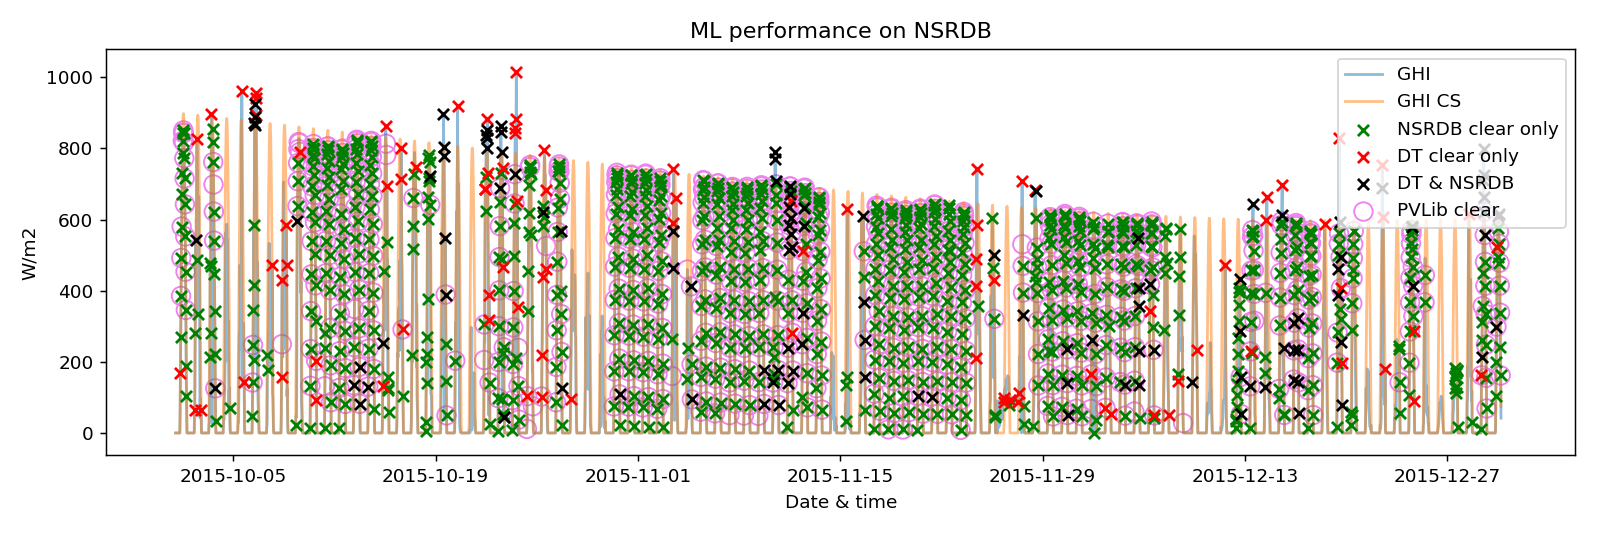

In [23]:
fig, ax = plt.subplots(figsize=(12, 4))

p1 = ax.plot(test_df.index, test_df['GHI'], label='GHI', alpha=.5)
p2 = ax.plot(test_df.index, test_df['Clearsky GHI'], label='GHI CS', alpha=.5)

p3 = ax.scatter(test_df[~(test_df['dt_clear'] == 1) & (train_df['sky_status'])].index,
                test_df[~(test_df['dt_clear'] == 1) & (train_df['sky_status'])]['GHI'],
                marker='x', color='green', label='NSRDB clear only', zorder=10)

p4 = ax.scatter(test_df[(test_df['dt_clear'] == 1) & ~(train_df['sky_status'])].index,
                test_df[(test_df['dt_clear'] == 1) & ~(train_df['sky_status'])]['GHI'],
                marker='x', color='red', label='DT clear only', zorder=10)

p5 = ax.scatter(test_df[(test_df['dt_clear'] == 1) & (train_df['sky_status'])].index,
                test_df[(test_df['dt_clear'] == 1) & (train_df['sky_status'])]['GHI'],
                marker='x', color='black', label='DT & NSRDB', zorder=10)

p6 = ax.scatter(test_df[test_df['sky_status']].index,
                test_df[test_df['sky_status']]['GHI'],
                marker='o', edgecolor='violet', facecolor='none', s=100, label='PVLib clear')

_ = ax.legend().set_zorder(100)

_ = ax.set_title('ML performance on NSRDB')
_ = ax.set_xlabel('Date & time')
_ = ax.set_ylabel('W/m2')

fig.tight_layout()


This is pretty disappointing performance.  We did see though (in the last notebook) that NSRDB expects GHI and GHI_cs to be extremely similar to be clear.  We will try scaling the clearsky model for ground based data to what the PVLib fit gives and re-running the DT classification.

#### Second run

In [24]:
train_df = nsrdb_df
test_df = ground_df[ground_df.index >= '10-01-2015']

In [25]:
cols = ['GHI', 'Clearsky GHI', 'ratio', 'sky_status']
dt = tree.DecisionTreeClassifier(max_depth=MAX_DEPTH)
dt.fit(train_df[cols[:-1]].values, train_df[cols[-1]].values)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [26]:
cols = ['GHI', 'Clearsky GHI scale', 'ratio scale', 'sky_status']

In [27]:
test_df['dt_clear'] = dt.predict(test_df[cols[:-1]])

/Users/benellis/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [28]:
train_df = train_df.loc[intersection]
test_df = test_df.loc[intersection]

<IPython.core.display.Javascript object>


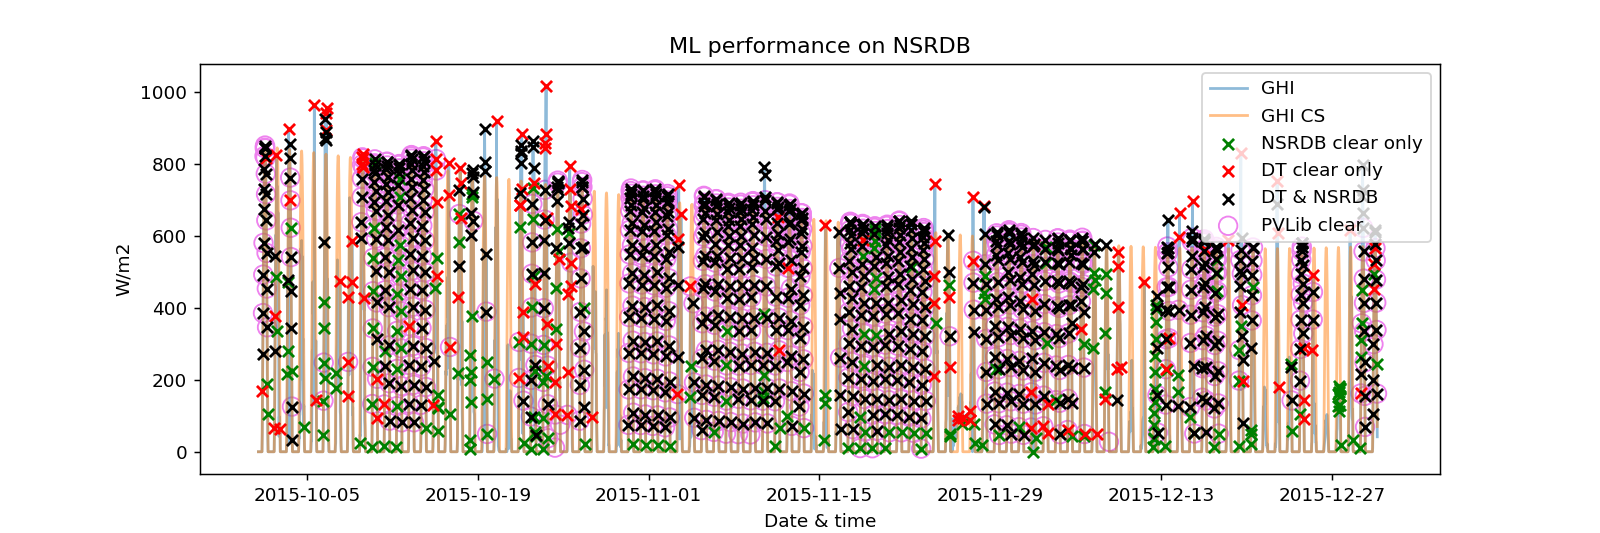

In [29]:
fig, ax = plt.subplots(figsize=(12, 4))

p1 = ax.plot(test_df.index, test_df['GHI'], label='GHI', alpha=.5)
p2 = ax.plot(test_df.index, test_df['Clearsky GHI scale'], label='GHI CS', alpha=.5)

p3 = ax.scatter(test_df[~(test_df['dt_clear'] == 1) & (train_df['sky_status'])].index,
                test_df[~(test_df['dt_clear'] == 1) & (train_df['sky_status'])]['GHI'],
                marker='x', color='green', label='NSRDB clear only', zorder=10)

p4 = ax.scatter(test_df[(test_df['dt_clear'] == 1) & ~(train_df['sky_status'])].index,
                test_df[(test_df['dt_clear'] == 1) & ~(train_df['sky_status'])]['GHI'],
                marker='x', color='red', label='DT clear only', zorder=10)

p4 = ax.scatter(test_df[(test_df['dt_clear'] == 1) & (train_df['sky_status'])].index,
                test_df[(test_df['dt_clear'] == 1) & (train_df['sky_status'])]['GHI'],
                marker='x', color='black', label='DT & NSRDB', zorder=10)

p6 = ax.scatter(test_df[test_df['sky_status']].index,
                test_df[test_df['sky_status']]['GHI'],
                marker='o', edgecolor='violet', facecolor='none', s=100, label='PVLib clear')

_ = ax.legend().set_zorder(100)

_ = ax.set_title('ML performance on NSRDB')
_ = ax.set_xlabel('Date & time')
_ = ax.set_ylabel('W/m2')


Dramatic improvement from previous.  This is evidence of the importance having a model that closely matches measured irradiance at clear periods is.  This is a potential drawback of the method.  Some strategies to address this could be iterative classification (scale model to GHI at clear periods until convergence - done in PVLib).  We could also generate a statistical clearsky which shouldn't really need scaling.  One thing we see is that high irradiance points are never rejected by the DT classification.